In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

from datetime import timedelta, datetime as dt
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.api import Holt

In [2]:
from acquire import opsd_germany_daily

In [3]:
df = opsd_germany_daily()

In [4]:
df.head()

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.184,NaN,NaN,NaN
1,2006-01-02,1380.521,NaN,NaN,NaN
2,2006-01-03,1442.533,NaN,NaN,NaN
3,2006-01-04,1457.217,NaN,NaN,NaN
4,2006-01-05,1477.131,NaN,NaN,NaN


In [5]:
from prepare import prep_german_data

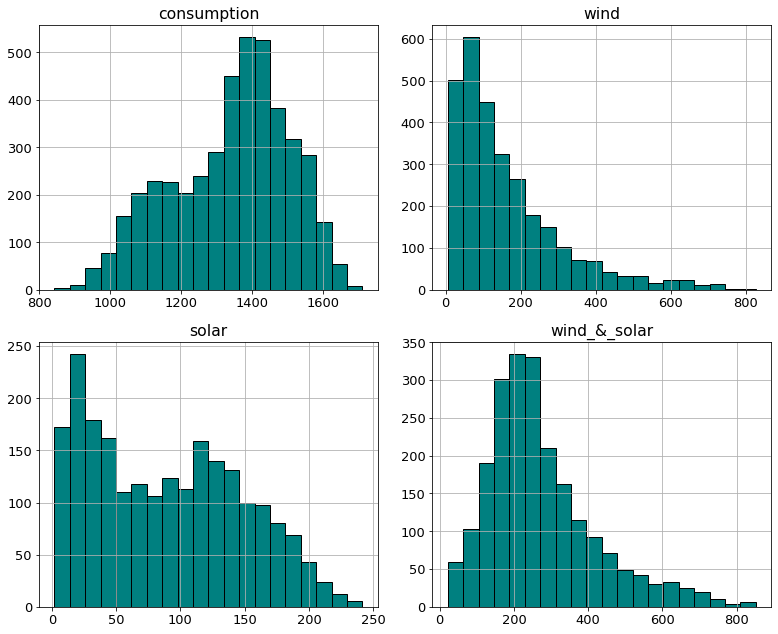

In [6]:
df = prep_german_data(df)

In [7]:
df.head()

,consumption,wind,solar,wind_&_solar,month,year
date,,,,,,
2006-01-01,1069.184,0.0,0.0,0.0,1,2006
2006-01-02,1380.521,0.0,0.0,0.0,1,2006
2006-01-03,1442.533,0.0,0.0,0.0,1,2006
2006-01-04,1457.217,0.0,0.0,0.0,1,2006
2006-01-05,1477.131,0.0,0.0,0.0,1,2006


In [8]:
# Date time already inputed and date is indexed
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4383 entries, 2006-01-01 to 2017-12-31
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   consumption   4383 non-null   float64
 1   wind          4383 non-null   float64
 2   solar         4383 non-null   float64
 3   wind_&_solar  4383 non-null   float64
 4   month         4383 non-null   int64  
 5   year          4383 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 239.7 KB


# Splitting the data¶

In [9]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

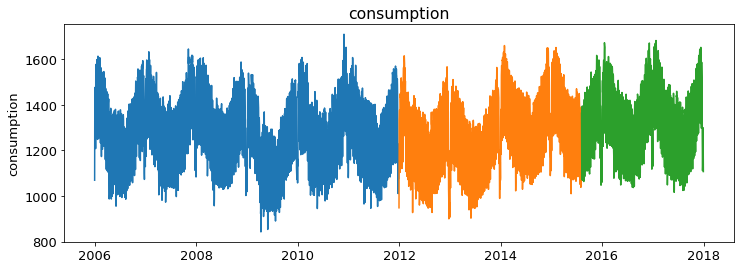

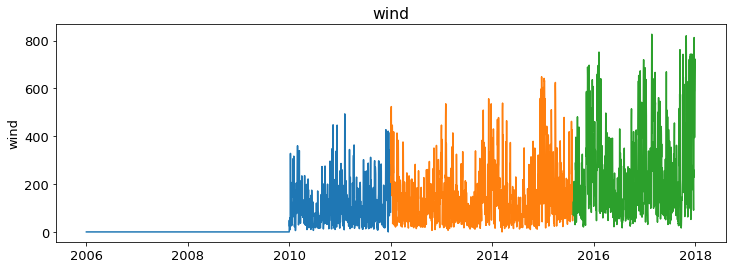

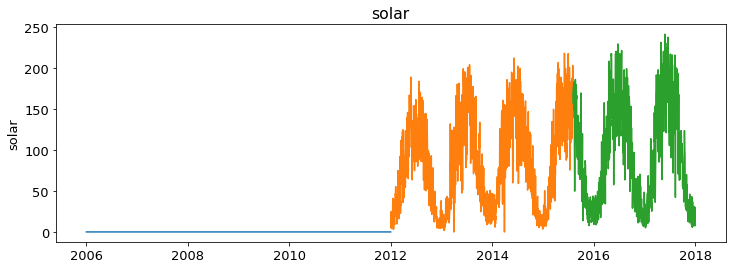

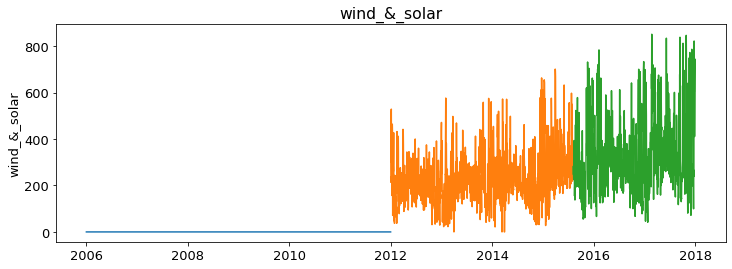

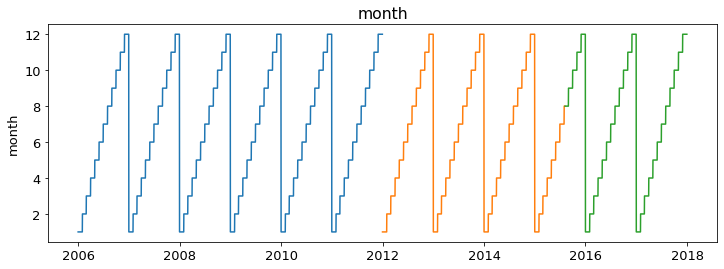

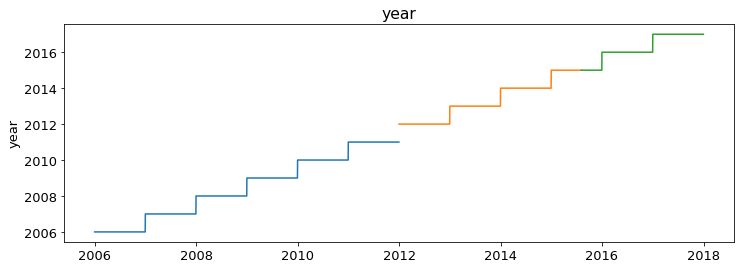

In [10]:
# Based on the graphs, solar started in 2012, going to make data frame to show all data starting with 2012
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [11]:
df= df['2012-01-01':]
df = df.drop(columns =['month','year'])

In [12]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

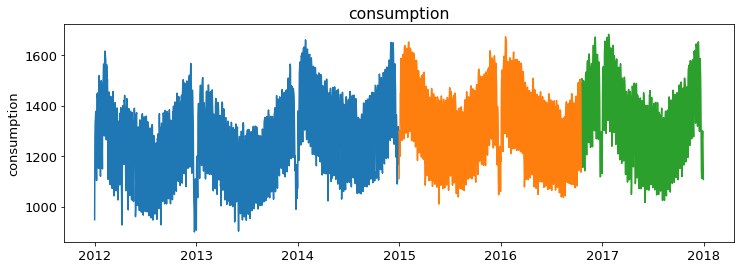

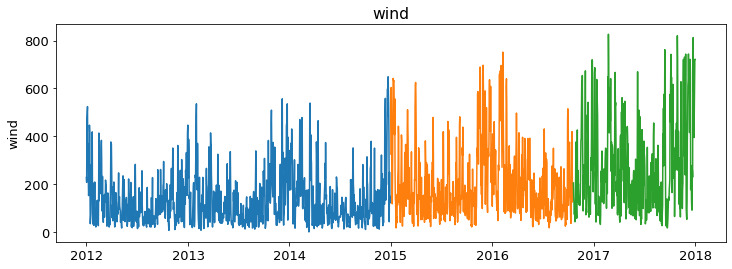

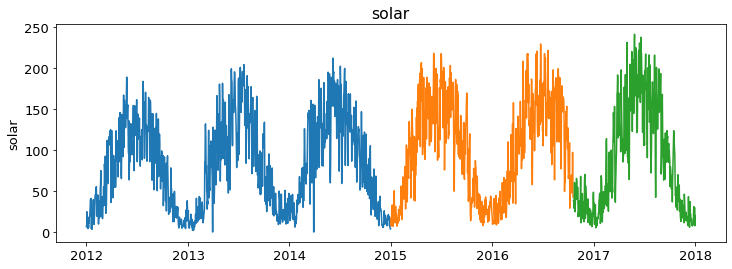

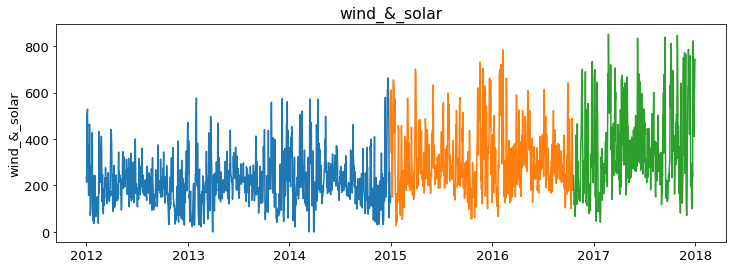

In [13]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

# Forecast
**Last observed value**
The simplest method for forecasting is to predict all future values to be the last observed value.

Make Predictions

In [14]:
#Taking the last 2 values and projecting them foward
train.tail()

,consumption,wind,solar,wind_&_solar
date,,,,
2014-12-27,1198.834,249.906,7.521,257.427
2014-12-28,1168.079,137.846,15.524,153.370
2014-12-29,1316.093,148.966,5.221,154.187
2014-12-30,1300.367,121.775,3.392,125.167
2014-12-31,1183.510,145.511,3.721,149.232


In [15]:
# [-1:] takes the last value consumption [0] selects the value
consumed = round(train['consumption'][-1:][0],2)
w = round(train['wind'][-1:][0],2)
s = round(train['solar'][-1:][0],2)
w_n_s= round(train['wind_&_solar'][-1:][0],2)

In [16]:
# Key is index is the **validate**. All values show the last values choosen
yhat_df = pd.DataFrame({'consumption': [consumed], 'wind': [w], 'solar': [s], 'wind_&_solar': [w_n_s]}, 
                       index = validate.index)

yhat_df.head()

,consumption,wind,solar,wind_&_solar
date,,,,
2015-01-01,1183.51,145.51,3.72,149.23
2015-01-02,1183.51,145.51,3.72,149.23
2015-01-03,1183.51,145.51,3.72,149.23
2015-01-04,1183.51,145.51,3.72,149.23
2015-01-05,1183.51,145.51,3.72,149.23


# Functions to help in modeling

In [17]:
# evaluation function to compute rmse
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [18]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [19]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

# You can see, when peeking into yhat_df, that every predicted value is the same.
**Plot Actual vs. Predicted Values**

Now, let's plot actual and predicted values

consumption -- RMSE: 250


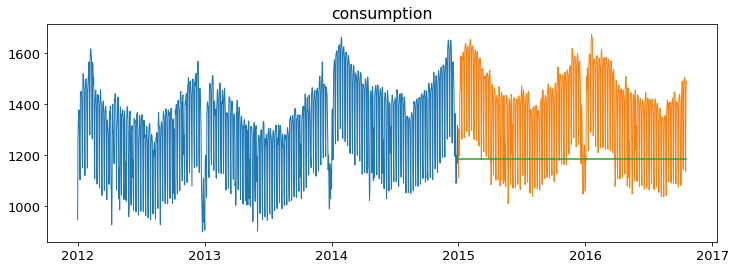

wind -- RMSE: 163


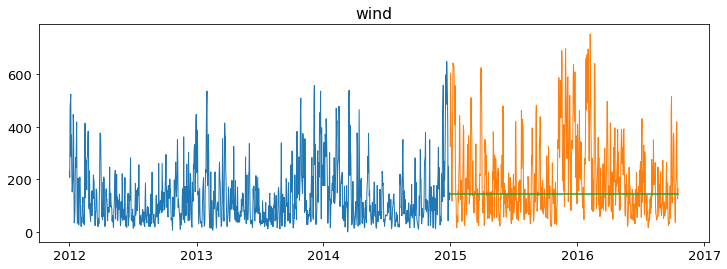

solar -- RMSE: 115


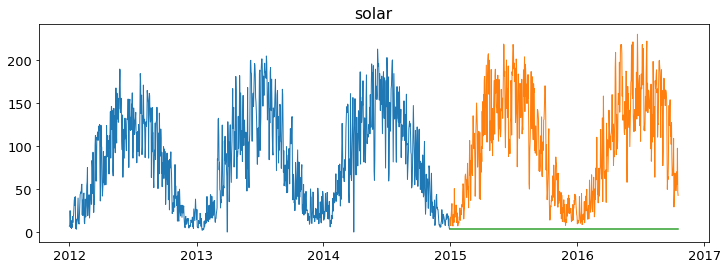

wind_&_solar -- RMSE: 211


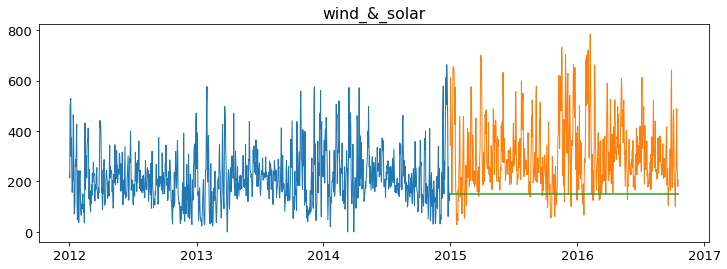

In [20]:
for col in train.columns:
    plot_and_eval(col)

## Evaluate

Evaluate using MSE and RMSE, and add evaluation metrics to eval_df

In [21]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_obs_value',
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_obs_value,consumption,250.0
1,last_obs_value,wind,163.0
2,last_obs_value,solar,115.0
3,last_obs_value,wind_&_solar,211.0


# Simple Average
Take the simple average of historical values and use that value to predict future values.

This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train.

**Make Predictions**

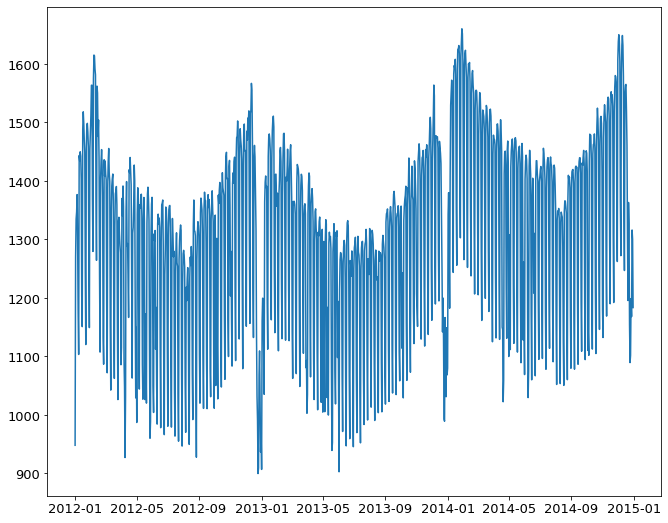

In [22]:
# compute the simple AVG for consumption
plt.plot(train['consumption'])
consumed = round(train['consumption'].mean(),2)

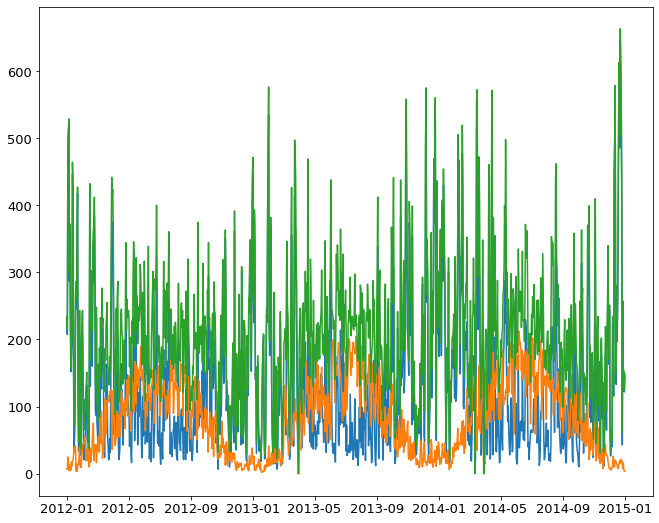

In [23]:
# For wind, solar and wind and solar now. establishing the values of the predictions we will make
plt.plot(train['wind'])
w = round(train['wind'].mean(),2)
plt.plot(train['solar'])
s = round(train['solar'].mean(),2)
plt.plot(train['wind_&_solar'])
w_n_s= round(train['wind_&_solar'].mean(),2)

In [24]:
# Making predictions
def make_predictions():
    yhat_df = pd.DataFrame({'consumption': [consumed], 'wind': [w], 'solar': [s], 'wind_&_solar': [w_n_s]
                           }, index = validate.index)
    return yhat_df

In [25]:
yhat_df = make_predictions()

In [26]:
yhat_df.head()

,consumption,wind,solar,wind_&_solar
date,,,,
2015-01-01,1311.2,131.54,82.07,213.34
2015-01-02,1311.2,131.54,82.07,213.34
2015-01-03,1311.2,131.54,82.07,213.34
2015-01-04,1311.2,131.54,82.07,213.34
2015-01-05,1311.2,131.54,82.07,213.34


### Plot Actual vs. Predicted Values

Now, let's plot and evaluate the performance of our time series model using Simple Average

consumption -- RMSE: 172


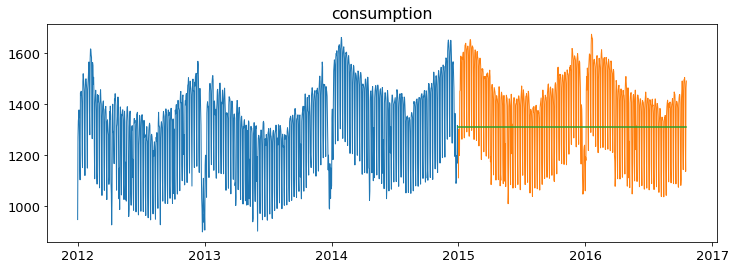

wind -- RMSE: 168


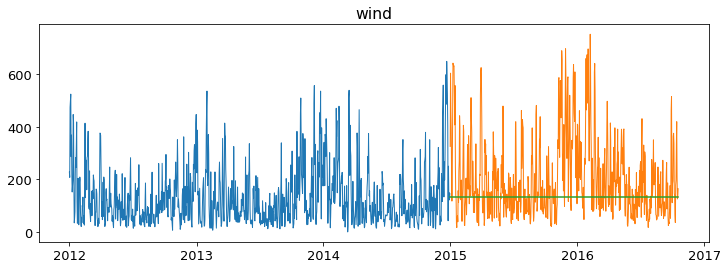

solar -- RMSE: 63


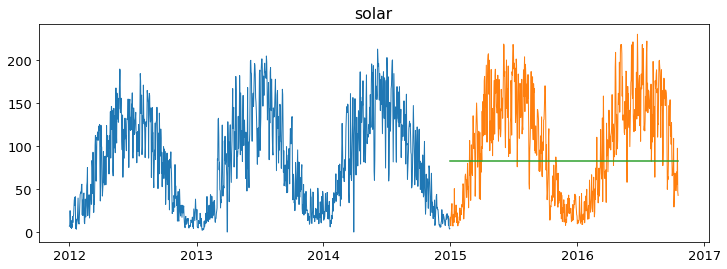

wind_&_solar -- RMSE: 168


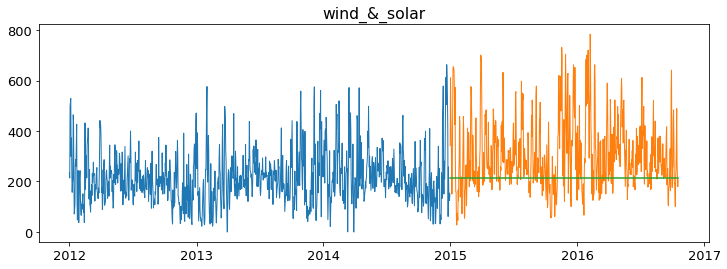

In [27]:
for col in train.columns:
    plot_and_eval(col)

## Evaluate
Evaluate using MSE and RMSE, and add evaluation metrics to eval_df



In [28]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_obs_value,consumption,250.0
1,last_obs_value,wind,163.0
2,last_obs_value,solar,115.0
3,last_obs_value,wind_&_solar,211.0
4,simple_average,consumption,172.0
5,simple_average,wind,168.0
6,simple_average,solar,63.0
7,simple_average,wind_&_solar,168.0


# Moving Average
In this example, we will use a 30-day moving average to forecast. In other words, the average over the last 30-days will be used as the forecasted value.

**Make Predictions**

In [71]:
def moving_avg(col):
    for col in train.columns:
        plt.figure(figsize=(12,4))
        plt.plot(train[col].rolling(7).mean())
        plt.plot(train[col].rolling(30).mean())
        plt.plot(train[col].rolling(90).mean())
        plt.plot(train[col].rolling(120).mean())
        plt.plot(train[col], alpha = .2)
        plt.show()
        

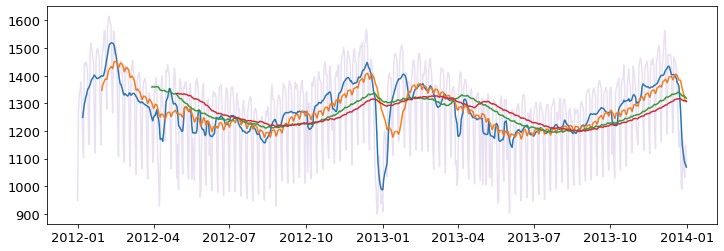

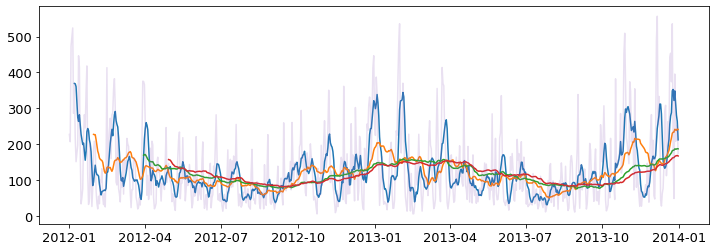

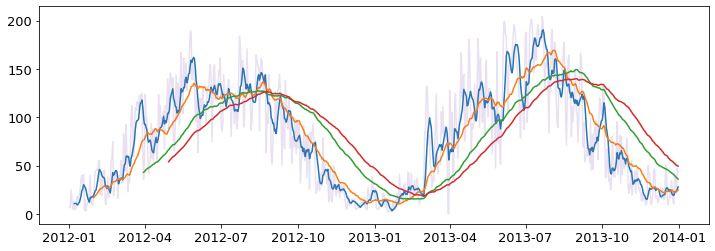

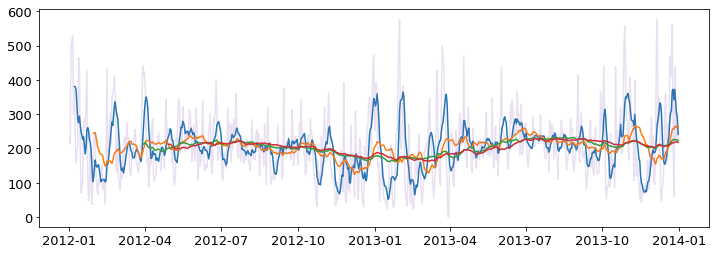

In [72]:
moving_avg(col)

# Make Predicitons


In [31]:
periods = [7, 30, 60, 90, 120]

for p in periods:
    consumed = round(train['consumption'].rolling(p).mean()[-1],2)
    w = round(train['wind'].rolling(p).mean()[-1],2)
    s = round(train['solar'].rolling(p).mean()[-1],2)
    w_n_s= round(train['wind_&_solar'].rolling(p).mean()[-1],2)
    #Uses consumed, w, s, and w_n_s from above to validate
    yhat_df = make_predictions()
    model_type = str(p) + 'd moving average'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                 target_var = col
                                )

In [32]:
eval_df

,model_type,target_var,rmse
0,last_obs_value,consumption,250.0
1,last_obs_value,wind,163.0
2,last_obs_value,solar,115.0
3,last_obs_value,wind_&_solar,211.0
4,simple_average,consumption,172.0
5,simple_average,wind,168.0
6,simple_average,solar,63.0
7,simple_average,wind_&_solar,168.0
8,7d moving average,consumption,242.0
9,7d moving average,wind,154.0


## Which is the best so far?

In [33]:
# Set allows you to get unique values in the list
rmse_list = set(eval_df.target_var.tolist())
rmse_list

{'consumption', 'solar', 'wind', 'wind_&_solar'}

In [34]:
def min_rmse(rmse_list):
    min_list = []
    for x in rmse_list:
        min_list.append(eval_df[eval_df.target_var == x].min())
    return min_list

In [35]:
min_rmse(rmse_list)

[model_type    120d moving average
 target_var           wind_&_solar
 rmse                          139
 dtype: object,
 model_type    120d moving average
 target_var                   wind
 rmse                          151
 dtype: object,
 model_type    120d moving average
 target_var                  solar
 rmse                           63
 dtype: object,
 model_type    120d moving average
 target_var            consumption
 rmse                          160
 dtype: object]

In [36]:
w_min_rmse = eval_df[eval_df.target_var == 'wind']['rmse'].min()
eval_df[eval_df.rmse == w_min_rmse]

,model_type,target_var,rmse
17,60d moving average,wind,151.0


In [37]:
s_min_rmse = eval_df[eval_df.target_var == 'solar']['rmse'].min()
eval_df[eval_df.rmse == s_min_rmse]

,model_type,target_var,rmse
6,simple_average,solar,63.0


In [38]:
w_s_min_rmse = eval_df[eval_df.target_var == 'wind_&_solar']['rmse'].min()
eval_df[eval_df.rmse == w_s_min_rmse]

,model_type,target_var,rmse
15,30d moving average,wind_&_solar,139.0


In [39]:
c_min_rmse = eval_df[eval_df.target_var == 'consumption']['rmse'].min()
eval_df[eval_df.rmse == c_min_rmse]

,model_type,target_var,rmse
24,120d moving average,consumption,160.0


# Holt's Linear Trend
### Exponential smoothing applied to both the average and the trend (slope).
- α / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.
- β / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values. Seasonal Decomposition

First, let's take a look at the seasonal decomposition for each target.

consumption 



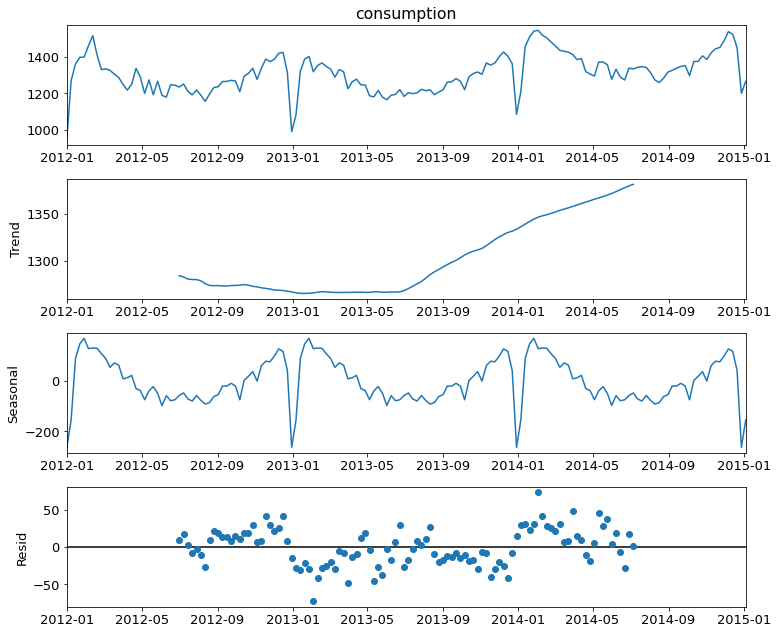

wind 



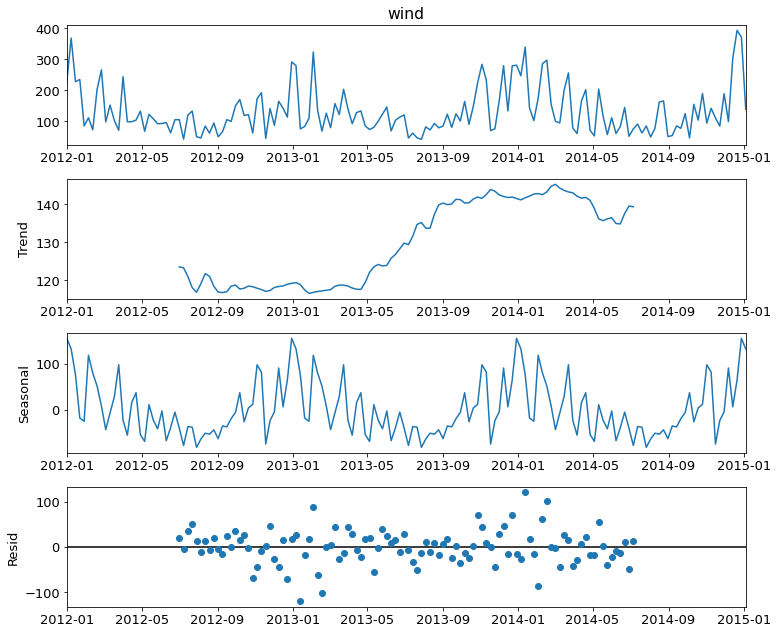

solar 



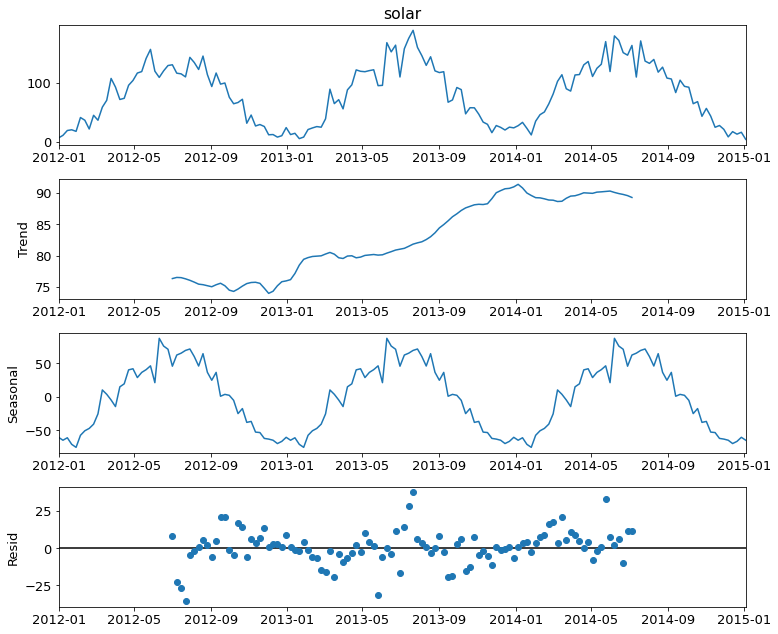

wind_&_solar 



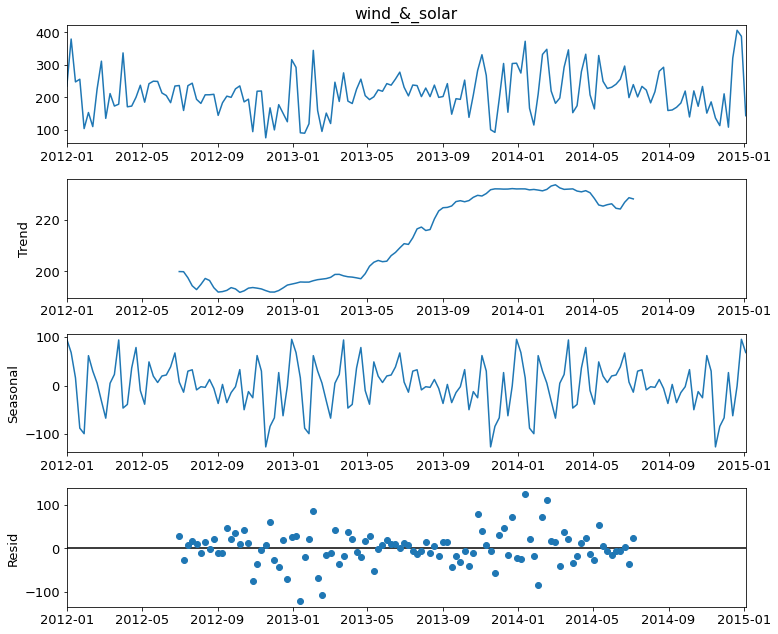

In [40]:
for col in train.columns:
    print(col,'\n') # new line
    sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()
    plt.show()

# Basic Holt's Linear Trend
## Make Predictions

Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions.

Holt:
- exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)

fit:
- smoothing_level (α): value between (0,1)
- smoothing_slope (β): value between (0,1)

In [41]:
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized = True)
    yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_items,2)

In [42]:
yhat_df.head(3)

,consumption,wind,solar,wind_&_solar
date,,,,
2015-01-01,1176.57,141.39,5.33,145.04
2015-01-02,1166.22,141.30,5.33,144.87
2015-01-03,1155.98,141.21,5.32,144.70


consumption -- RMSE: 1118


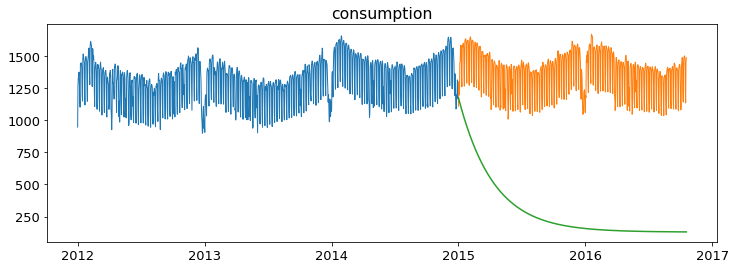

wind -- RMSE: 167


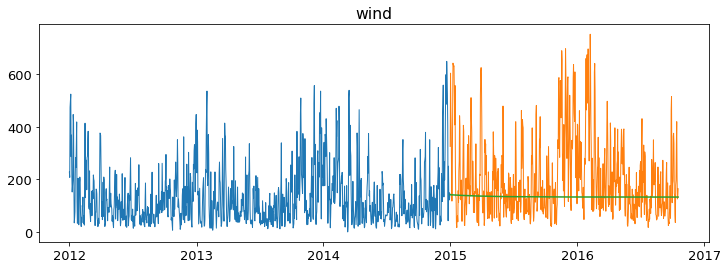

solar -- RMSE: 114


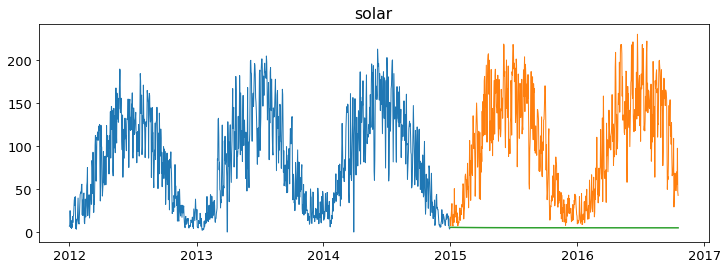

wind_&_solar -- RMSE: 225


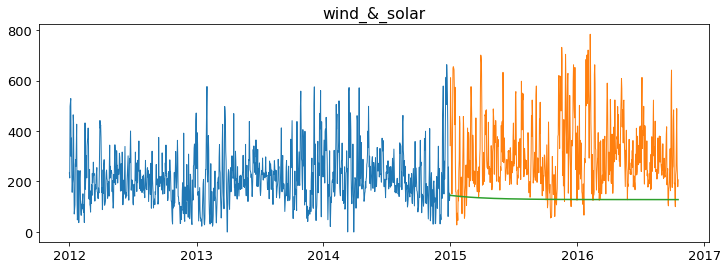

In [43]:
for col in train.columns:
    plot_and_eval(target_var = col)

# Evaluate

In [44]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized',
                            target_var = col)

In [45]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
6,simple_average,solar,63.0
26,120d moving average,solar,79.0
22,90d moving average,solar,90.0
18,60d moving average,solar,100.0
14,30d moving average,solar,107.0
10,7d moving average,solar,110.0
30,holts_optimized,solar,114.0
2,last_obs_value,solar,115.0
15,30d moving average,wind_&_solar,139.0
17,60d moving average,wind,151.0


# Adjusting some hyperperameters

In [46]:
for col in train.columns:
    model = Holt(train[col], exponential=False)
    model = model.fit(optimized = False, smoothing_level = .4, 
                      smoothing_slope = .1)
    yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_items,2)

consumption -- RMSE: 4074


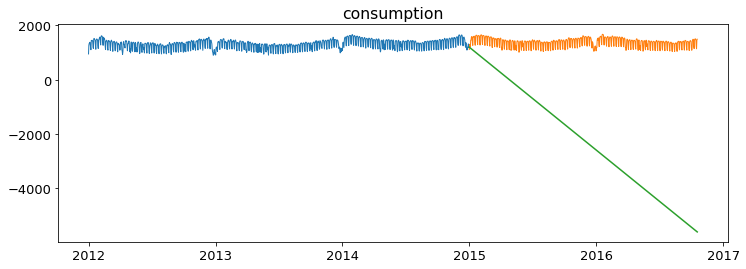

wind -- RMSE: 7314


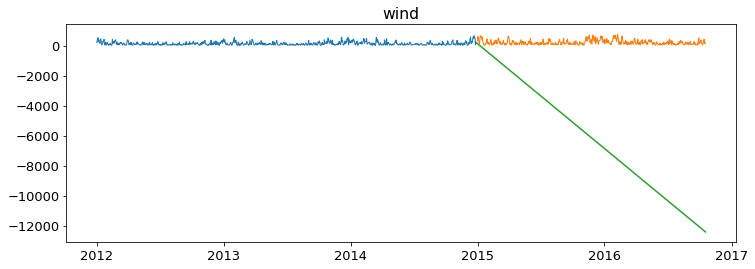

solar -- RMSE: 423


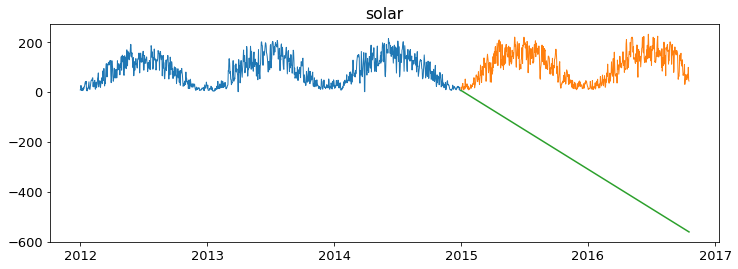

wind_&_solar -- RMSE: 7731


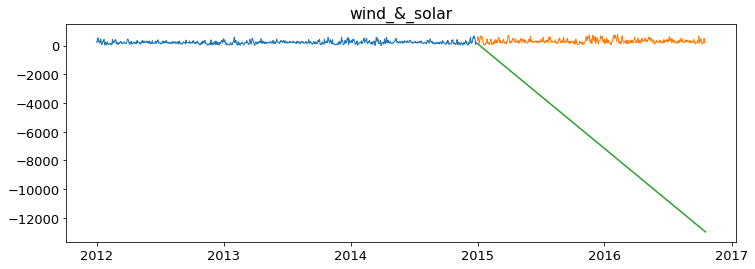

In [47]:
for col in train.columns:
    plot_and_eval(target_var = col)

# Predict Based on Previous Cycle
Take all the 2016 data points, compute the daily delta, year-over-year, average that delta over all the days, and adding that average to the previous year's value on a day will give you the forecast for that day.

If a primary cycle is weekly, then you may want to do this on a week-over-week cadence.

In the below example:

1. Compute the 365 average year over year differences from 2013 through 2015
2. Add that average delta to the values during 2015.
3. Set the index in your yhat dataframe to represent the dates those predictions are make for.
Let's get started....

Re-split data

In [48]:
train = df[:'2013']
validate = df['2014']
test = df['2015']
print(train.shape)
print(validate.shape)
print(test.shape)

(731, 4)
(365, 4)
(365, 4)


# Make Predictions

In [49]:
# Finding the yr over yr difference for each day from 13 to 15
yhat_df = train['2013'] + train.diff(365).mean()

In [50]:
# taking a peek into the prediction we will make for 1/1/2014 by comparing the predicted value
# (2013 value + yr over yr avg difference) to the actual 1/1/2014
pd.concat([yhat_df.head(1), validate.head(1)])

,consumption,wind,solar,wind_&_solar
date,,,,
2013-01-01,892.516309,267.305915,18.856101,285.99762
2014-01-01,1080.080000,220.085000,30.493000,250.57800


In [51]:
# set yhat _df to index of validate

yhat_df.index = validate.index

yhat_df.describe

<bound method NDFrame.describe of             consumption        wind      solar  wind_&_solar
date                                                        
2014-01-01   892.516309  267.305915  18.856101     285.99762
2014-01-02  1145.780309  229.734915  30.648101     260.21862
2014-01-03  1185.171309  392.010915  10.696101     402.54262
2014-01-04  1184.558309  347.310915   9.614101     356.76062
2014-01-05  1093.877309  145.277915   9.608101     154.72162
...                 ...         ...        ...           ...
2014-12-27  1152.158309  400.603915  45.649101     446.08862
2014-12-28  1075.396309  213.381915  25.666101     238.88362
2014-12-29  1016.755309  218.845915  25.571101     244.25262
2014-12-30  1134.703309  258.986915  51.735101     310.55762
2014-12-31  1054.035309  179.537915  47.857101     227.23062

[365 rows x 4 columns]>

consumption -- RMSE: 198


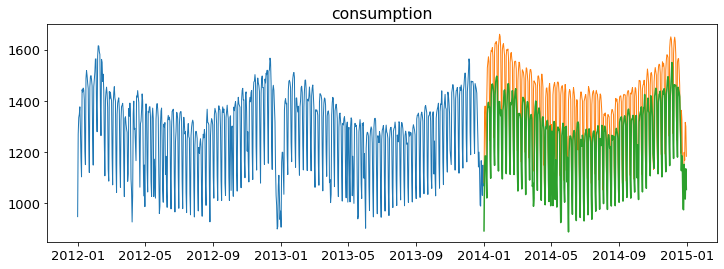

wind -- RMSE: 146


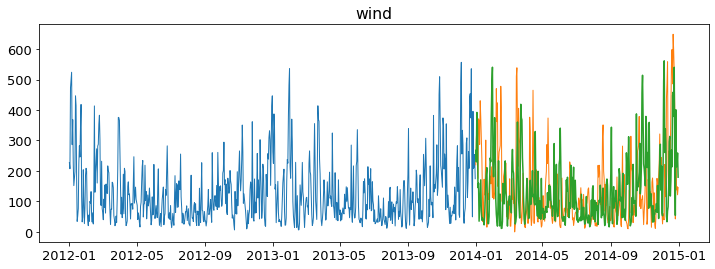

solar -- RMSE: 40


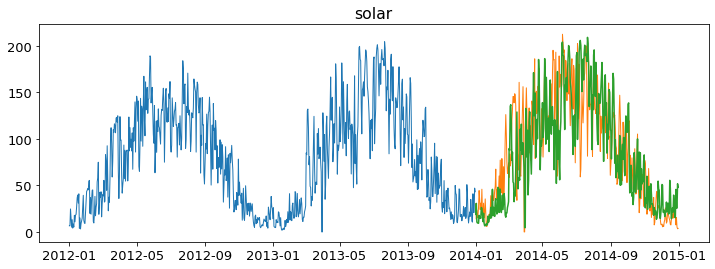

wind_&_solar -- RMSE: 149


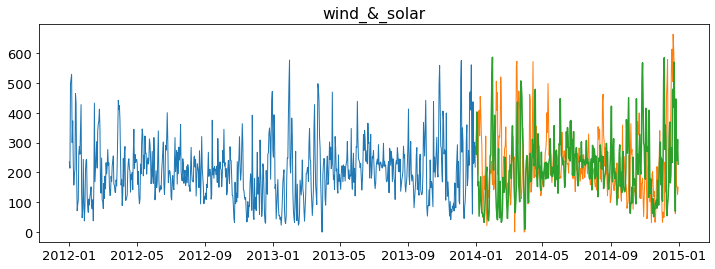

In [52]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)


In [53]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
34,previous year,solar,40.0
6,simple_average,solar,63.0
26,120d moving average,solar,79.0
22,90d moving average,solar,90.0
18,60d moving average,solar,100.0
14,30d moving average,solar,107.0
10,7d moving average,solar,110.0
30,holts_optimized,solar,114.0
2,last_obs_value,solar,115.0
15,30d moving average,wind_&_solar,139.0


### Let's test it out on our out-of-sample data
We will be using train + validate to predict test.

In [54]:
yhat_df = validate + train.diff(365).mean()
yhat_df.index = test.index

In [59]:
def final_plot(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], alpha = .5)
    plt.title(target_var)
    plt.show()

In [60]:
rmse_solar = sqrt(mean_squared_error(test['solar'], yhat_df['solar']))
rmse_wind = sqrt(mean_squared_error(test['wind'], yhat_df['wind']))

rmse - solar:  40.49683197734869
rmse - wind:  188.47947357777318


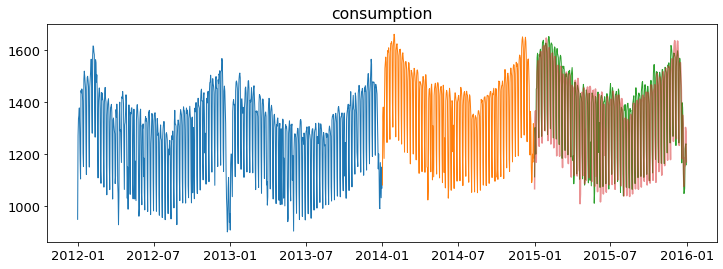

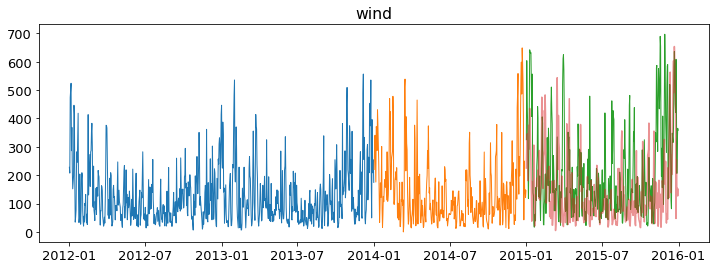

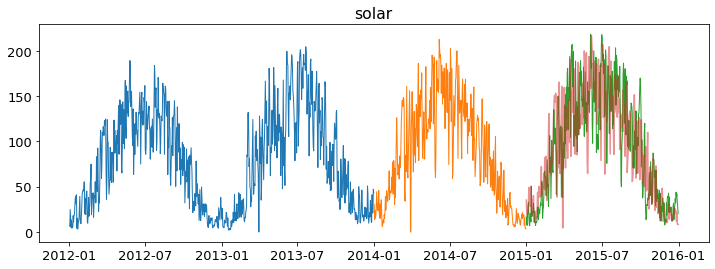

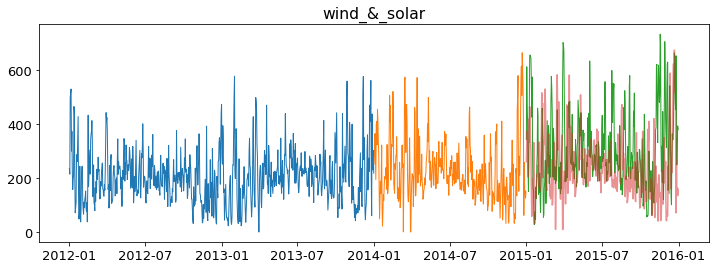

In [61]:
print("rmse - solar: ", rmse_solar)
print("rmse - wind: ", rmse_wind)

for col in train.columns:
    final_plot(col)

In [73]:
# to predict 2017

yhat_df = test + train.diff(365).mean()

yhat_df.index = test.index + pd.Timedelta('1Y')

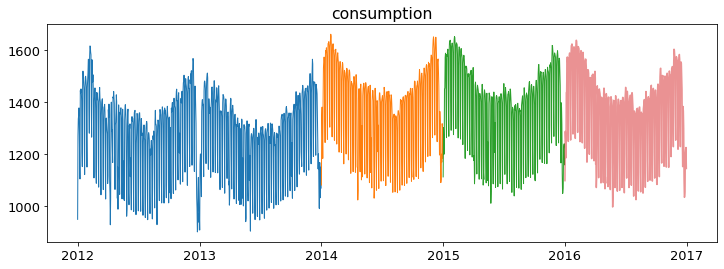

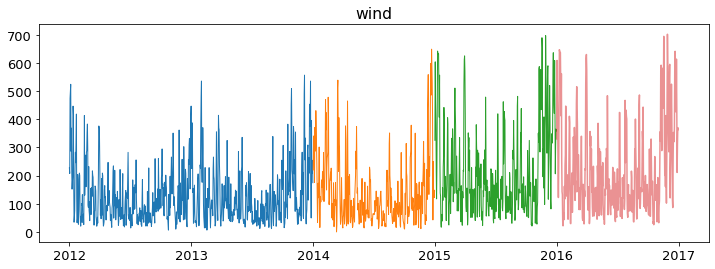

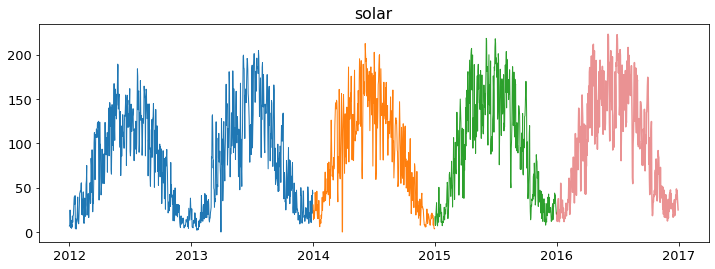

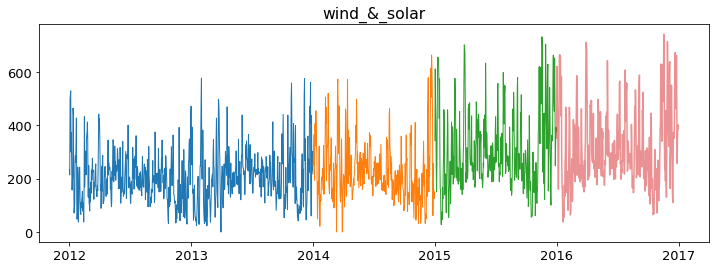

In [74]:
for col in train.columns:
    final_plot(col)